# Task 02

In [2]:
import math, numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym

In [ ]:
def make_env(seed=42, is_slippery=True, map_name="4x4"):
    env = gym.make("FrozenLake-v1", is_slippery=is_slippery, map_name=map_name)
    env.reset(seed=seed)
    P = env.unwrapped.P 
    nS = env.observation_space.n
    nA = env.action_space.n
    return env, nS, nA, P

env, nS, nA, P = make_env(seed=42, is_slippery=True, map_name="4x4")
print(f"Entorno listo. nS={nS}, nA={nA}")

Entorno listo. nS=16, nA=4


In [ ]:
def moving_average(x, w=20):
    x = np.asarray(x, dtype=float)
    if len(x) < w: return x
    c = np.cumsum(np.insert(x, 0, 0.0))
    return (c[w:] - c[:-w]) / float(w)

def plot_series(y, title, xlabel, ylabel):
    plt.figure()
    plt.plot(y)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

def is_terminal_from_P(P, s):
    return all(out[3] for out in P[s][0])

def sample_from_P(P, s, a, rng):
    outcomes = P[s][a]
    probs = [o[0] for o in outcomes]
    idx = rng.choice(len(outcomes), p=probs)
    _, ns, r, done = outcomes[idx]
    return ns, r, bool(done)


## MCTS (UCT)

In [ ]:
class MCTSNode:
    __slots__ = ("state", "parent", "children", "N", "W", "untried_actions", "is_terminal")
    def __init__(self, state, parent=None, nA=4, is_terminal=False):
        self.state = state
        self.parent = parent
        self.children = {}     
        self.N = 0              
        self.W = 0.0            
        self.untried_actions = list(range(nA))
        self.is_terminal = is_terminal

def uct_score(parent, child, c=1.414213562):
    if child.N == 0: return float("inf")
    return (child.W / child.N) + c * math.sqrt(math.log(parent.N + 1) / child.N)

def mcts_select(node, c=1.414213562):
    cur = node
    while (not cur.is_terminal) and (len(cur.untried_actions) == 0) and (len(cur.children) > 0):
        _, cur = max(cur.children.items(), key=lambda kv: uct_score(cur, kv[1], c))
    return cur

def mcts_expand(node, P, nA, rng):
    if node.is_terminal or not node.untried_actions:
        return node, 0.0
    a = node.untried_actions.pop(rng.integers(len(node.untried_actions)))
    ns, r, done = sample_from_P(P, node.state, a, rng)
    child = MCTSNode(ns, parent=node, nA=nA, is_terminal=done or is_terminal_from_P(P, ns))
    node.children[a] = child
    return child, r

def mcts_rollout(state, P, rng, max_depth=50, gamma=0.99):
    total, g, s = 0.0, 1.0, state
    for _ in range(max_depth):
        if is_terminal_from_P(P, s): break
        a = int(rng.integers(0, 4))
        ns, r, done = sample_from_P(P, s, a, rng)
        total += g * r
        g *= gamma
        s = ns
        if done: break
    return total

def mcts_backprop(node, reward):
    cur = node
    while cur is not None:
        cur.N += 1
        cur.W += reward
        cur = cur.parent

def mcts_action(P, root_state, nA, sims_per_move=200, c=1.4142, gamma=0.99, max_depth=50, seed=None):
    rng = np.random.default_rng(seed)
    root = MCTSNode(root_state, parent=None, nA=nA, is_terminal=is_terminal_from_P(P, root_state))
    for _ in range(sims_per_move):
        node = mcts_select(root, c)
        if node.is_terminal:
            mcts_backprop(node, 0.0)
            continue
        new_node, r = mcts_expand(node, P, nA, rng)
        reward = r + gamma * mcts_rollout(new_node.state, P, rng, max_depth=max_depth, gamma=gamma)
        mcts_backprop(new_node, reward)
    if len(root.children) == 0:
        return int(np.random.default_rng().integers(nA))
    best_a = max(root.children.items(), key=lambda kv: kv[1].N)[0]
    return int(best_a)

## Dyna-Q+

In [ ]:
def dyna_q_plus(env, nS, nA, episodes=500, alpha=0.1, gamma=0.99, epsilon=0.1,
                planning_steps=20, kappa=1e-3, max_steps=200, seed=0):
    rng = np.random.default_rng(seed)
    Q = np.zeros((nS, nA), dtype=float)

    model_r  = np.zeros((nS, nA), dtype=float)
    model_ns = np.zeros((nS, nA), dtype=int)
    model_done = np.zeros((nS, nA), dtype=bool)
    last_tried = np.zeros((nS, nA), dtype=int)

    visited_sa = np.zeros((nS, nA), dtype=bool)
    total_sa = nS * nA

    rewards, success, steps_to_goal, visited_ratio = [], [], [], []
    t_global = 0

    for ep in range(episodes):
        s, _ = env.reset()
        ep_rew, steps, ok = 0.0, 0, 0

        for _ in range(max_steps):
            t_global += 1
            a = int(rng.integers(nA)) if (rng.random() < epsilon) else int(np.argmax(Q[s]))
            ns, r, terminated, truncated, _ = env.step(a)
            done = bool(terminated or truncated)

            td_target = r + gamma * (0.0 if done else np.max(Q[ns]))
            Q[s, a] += alpha * (td_target - Q[s, a])

            model_r[s, a] = r
            model_ns[s, a] = ns
            model_done[s, a] = done
            last_tried[s, a] = t_global
            visited_sa[s, a] = True

            s = ns
            ep_rew += r
            steps += 1

            seen = np.argwhere(last_tried > 0)
            for _p in range(min(planning_steps, len(seen))):
                sp, ap = seen[rng.integers(len(seen))]
                bonus = kappa * math.sqrt(max(0, t_global - last_tried[sp, ap]))
                rp = model_r[sp, ap] + bonus
                nsp = model_ns[sp, ap]
                td_target_p = rp + gamma * (0.0 if model_done[sp, ap] else np.max(Q[nsp]))
                Q[sp, ap] += alpha * (td_target_p - Q[sp, ap])

            if done:
                ok = 1 if r > 0 else 0
                break

        rewards.append(ep_rew)
        success.append(ok)
        steps_to_goal.append(steps if ok == 1 else np.nan)
        visited_ratio.append(np.count_nonzero(visited_sa) / total_sa)

    return {
        "Q": Q,
        "rewards": np.array(rewards, float),
        "success": np.array(success, float),
        "steps_to_goal": np.array(steps_to_goal, float),
        "visited_ratio": np.array(visited_ratio, float),
    }

In [7]:
def mcts_run(env, P, nS, nA, episodes=300, sims_per_move=150, c=1.2,
             gamma=0.99, max_depth=50, max_steps=200, seed=1):
    rewards, success, steps_to_goal = [], [], []
    for ep in range(episodes):
        s, _ = env.reset(seed=int(seed + ep))
        ep_rew, steps, ok = 0.0, 0, 0
        for _ in range(max_steps):
            a = mcts_action(P, s, nA, sims_per_move=sims_per_move, c=c, gamma=gamma, max_depth=max_depth, seed=seed+ep)
            ns, r, terminated, truncated, _ = env.step(a)
            ep_rew += r
            steps += 1
            s = ns
            if terminated or truncated:
                ok = 1 if r > 0 else 0
                break
        rewards.append(ep_rew)
        success.append(ok)
        steps_to_goal.append(steps if ok == 1 else np.nan)
    return {
        "rewards": np.array(rewards, float),
        "success": np.array(success, float),
        "steps_to_goal": np.array(steps_to_goal, float),
    }


In [8]:
EPISODES_MCTS = 300
EPISODES_DYNA = 500

mcts_cfg = dict(episodes=EPISODES_MCTS, sims_per_move=150, c=1.2, gamma=0.99, max_depth=50, max_steps=200, seed=1)
dyna_cfg = dict(episodes=EPISODES_DYNA, alpha=0.15, gamma=0.99, epsilon=0.10, planning_steps=25, kappa=1e-3, max_steps=200, seed=2)

print("Corriendo MCTS...")
res_mcts = mcts_run(env, P, nS, nA, **mcts_cfg)
print("Listo MCTS.")

print("Corriendo Dyna-Q+...")
res_dyna = dyna_q_plus(env, nS, nA, **dyna_cfg)
print("Listo Dyna-Q+.")


Corriendo MCTS...
Listo MCTS.
Corriendo Dyna-Q+...
Listo Dyna-Q+.


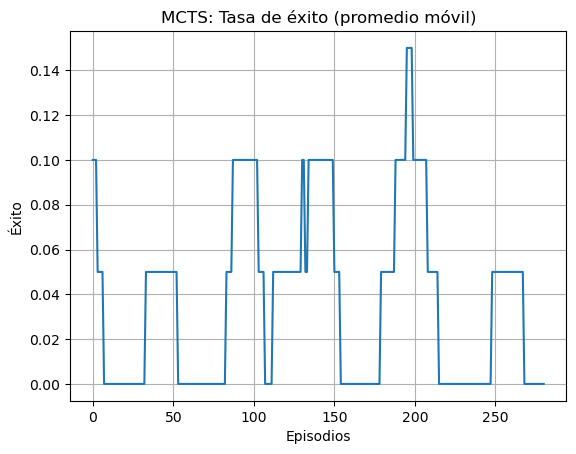

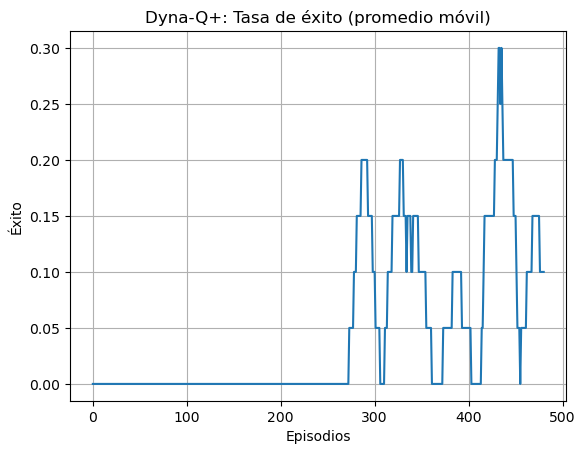

In [9]:
ma_win = 20
mcts_success_ma = moving_average(res_mcts["success"], w=ma_win)
dyna_success_ma = moving_average(res_dyna["success"], w=ma_win)

plot_series(mcts_success_ma, "MCTS: Tasa de éxito (promedio móvil)", "Episodios", "Éxito")
plot_series(dyna_success_ma, "Dyna-Q+: Tasa de éxito (promedio móvil)", "Episodios", "Éxito")


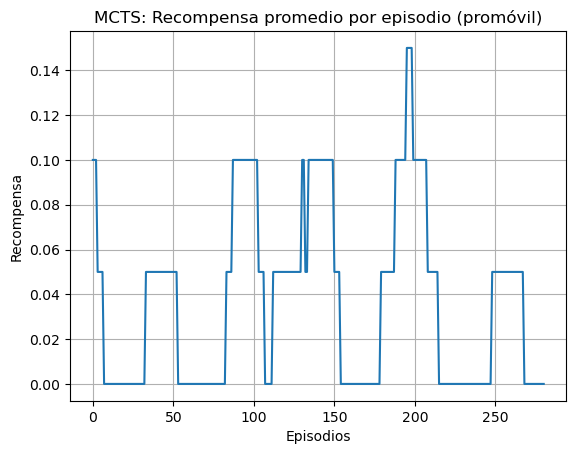

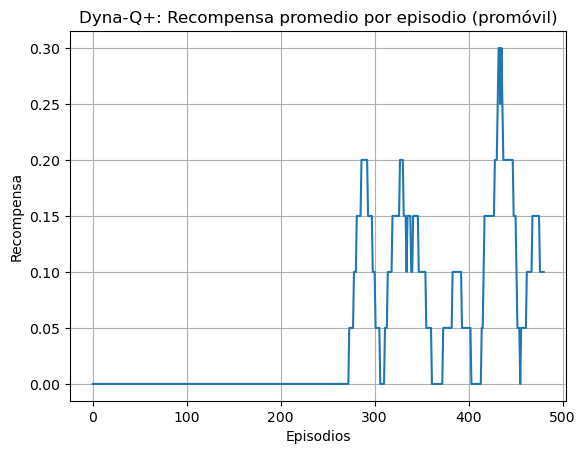

In [10]:
mcts_rew_ma = moving_average(res_mcts["rewards"], w=ma_win)
dyna_rew_ma = moving_average(res_dyna["rewards"], w=ma_win)

plot_series(mcts_rew_ma, "MCTS: Recompensa promedio por episodio (promóvil)", "Episodios", "Recompensa")
plot_series(dyna_rew_ma, "Dyna-Q+: Recompensa promedio por episodio (promóvil)", "Episodios", "Recompensa")

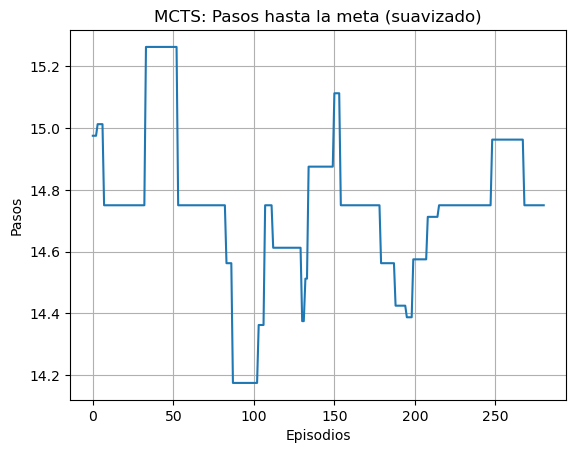

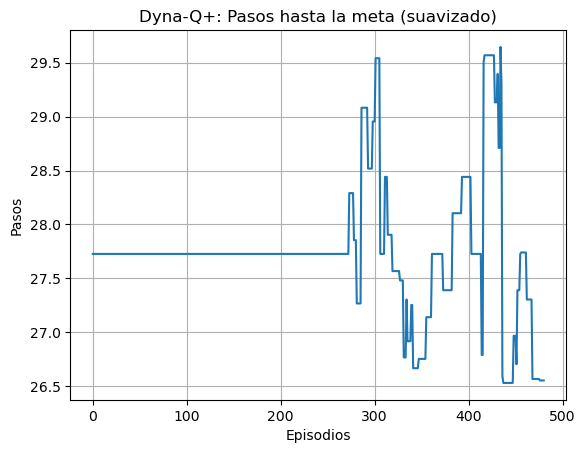

In [11]:
def replace_nan_with_mean(y):
    y = np.array(y, dtype=float)
    if np.all(np.isnan(y)): return y
    mean_val = np.nanmean(y)
    return np.where(np.isnan(y), mean_val, y)

mcts_steps_ma = moving_average(replace_nan_with_mean(res_mcts["steps_to_goal"]), w=ma_win)
dyna_steps_ma = moving_average(replace_nan_with_mean(res_dyna["steps_to_goal"]), w=ma_win)

plot_series(mcts_steps_ma, "MCTS: Pasos hasta la meta (suavizado)", "Episodios", "Pasos")
plot_series(dyna_steps_ma, "Dyna-Q+: Pasos hasta la meta (suavizado)", "Episodios", "Pasos")

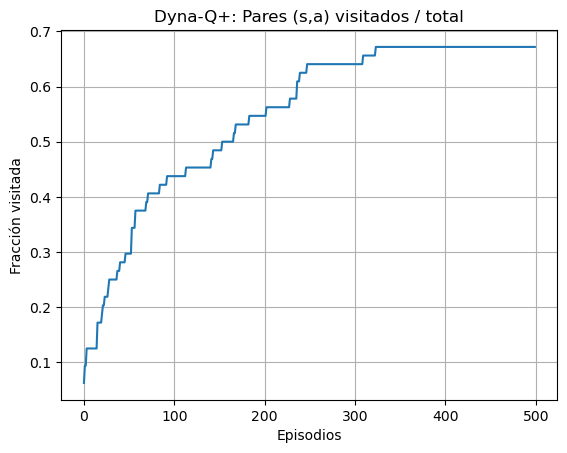

In [12]:
plot_series(res_dyna["visited_ratio"], "Dyna-Q+: Pares (s,a) visitados / total", "Episodios", "Fracción visitada")